<a href="https://colab.research.google.com/github/ArpitRawat07/DeepLearning_ImageClassification/blob/main/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction
Transfer Learning is levaraging a working model's existing architecture and learned patterns for our own problems.
There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problem similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# GPU
!nvidia-smi

Tue Jan  9 14:04:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Get data (10% of food classes from Food101)
import zipfile

# Dowloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-01-09 14:04:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2024-01-09 14:04:28 (193 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through 10 percent data directory and list number of files
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

test_data = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training(before it trains too long and overfits) with the EarlyStopping callback.

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to:{log_dir}")
  return tensorboard_callback

In [6]:
# let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str) : A Tensorflow HUB feature extraction URL.
    num_classes (int) : Number of output neurons in the output layer.
      should be equal to number of target classes, default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                             num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [12]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log file to:tensorflow_hub/resnet50V2/2024-01-09_14:04:42
Epoch 1/5
24/24 [==============================] - 24s 623ms/step - loss: 1.9312 - accuracy: 0.3387 - val_loss: 1.2379 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 11s 480ms/step - loss: 0.9194 - accuracy: 0.7320 - val_loss: 0.8508 - val_accuracy: 0.7292
Epoch 3/5
24/24 [==============================] - 11s 485ms/step - loss: 0.6279 - accuracy: 0.8187 - val_loss: 0.7471 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 11s 486ms/step - loss: 0.4814 - accuracy: 0.8733 - val_loss: 0.7002 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 12s 518ms/step - loss: 0.3862 - accuracy: 0.9107 - val_loss: 0.6647 - val_accuracy: 0.7808


In [13]:
# Plotting loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

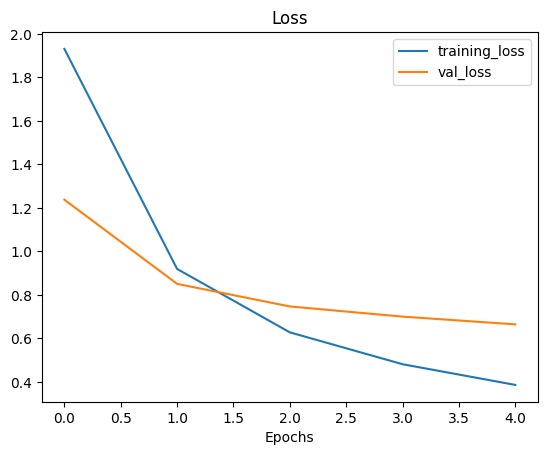

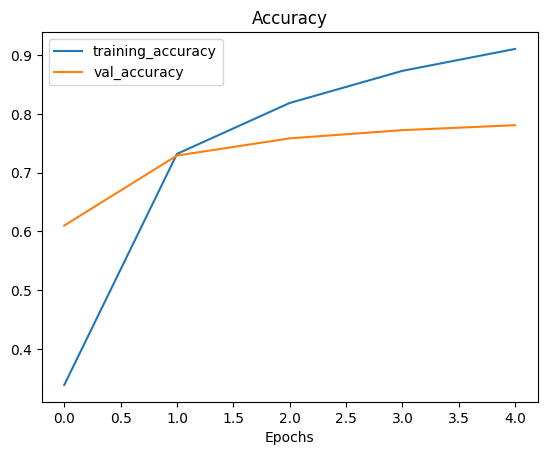

In [14]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [22]:
# Creating efficientnetb0 model
efficientnet_model = create_model(efficient_url,
                               num_classes=train_data_10_percent.num_classes)

In [23]:
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [24]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [25]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='EfficientNetB0')],
                                        )

Saving TensorBoard log file to:tensorflow_hub/EfficientNetB0/2024-01-09_14:31:56
Epoch 1/5
24/24 [==============================] - 20s 497ms/step - loss: 1.8791 - accuracy: 0.4067 - val_loss: 1.3070 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 11s 451ms/step - loss: 1.0780 - accuracy: 0.7613 - val_loss: 0.8731 - val_accuracy: 0.8136
Epoch 3/5
24/24 [==============================] - 10s 421ms/step - loss: 0.7704 - accuracy: 0.8293 - val_loss: 0.7004 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.6210 - accuracy: 0.8587 - val_loss: 0.6127 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 11s 455ms/step - loss: 0.5254 - accuracy: 0.8880 - val_loss: 0.5580 - val_accuracy: 0.8624


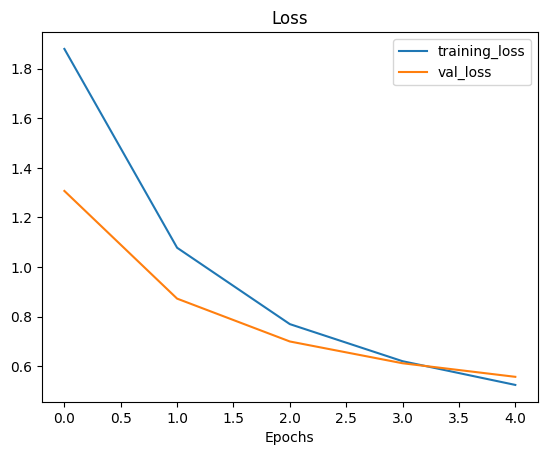

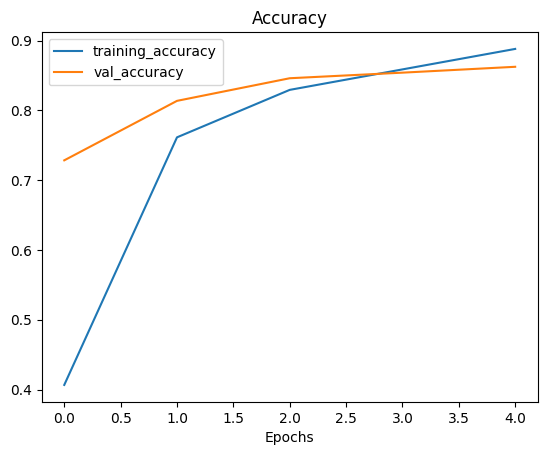

In [26]:
plot_loss_curves(efficientnet_history)